In [1]:
%pip install torchbnn

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import matplotlib.pyplot as plt
# import scipy.stats as st
import torchbnn as bnn
import torch.nn as nn
import seaborn as sns
import pandas as pd
import numpy as np

import itertools
import warnings
import torch

from torch.utils.data import DataLoader, TensorDataset, Dataset
from copy import deepcopy

from wave_generator import WaveGen

In [3]:
# def torch_train_test_timesplit(*tensors, start_idx=None, split=.8, size=1000):
#     # if start_idx is None, generate random start
#     train_size = int(split * size) if isinstance(split, float) else split
#     test_size = size - train_size

#     data_tensors = list()
#     for tensor in tensors:
#         start_idx = torch.randint(0, tensor.shape[0] - size, 1) if start_idx is None else start_idx
#         assert start_idx < tensor.shape[0] - size, f'Start index {start_idx} is too large for size {tensor.shape[0]} tensor with full size of {size}'
#         train_indices = torch.linspace(start_idx, train_size + start_idx, train_size)
#         test_indices = torch.linspace(train_size + start_idx, test_size + train_size + start_idx, test_size)
#         train_data = tensor[train_indices]
#         test_data = tensor[test_indices]
#         data_tensors.extend((train_data, test_data))
#     return data_tensors
   
class TorchTimesplitDataset(Dataset):
    def __init__(self, signal_tensor, split=990, size=1000):
        if size > len(signal_tensor):
            raise ValueError(f'Size of {size} is longer than signal of length {len(signal_tensor)}')
        if signal_tensor.dim() == 2:
            assert signal_tensor.shape[1] == 1
            self._signal = signal_tensor
        elif signal_tensor.dim() == 1:
            self._signal = signal_tensor.unsqueeze(dim=-1)
        else:
            raise ValueError('Expected 2 dimensional tensor with last dimension shape of 1')
        self.train_size = int(split * size) if 0 < split < 1 else int(split)
        self.test_size = int(size) - self.train_size
        self._size = int(size)
        return
    
    @property
    def shape(self):
        return int(self._signal.shape[0] - self._size),

    def __len__(self):
        return int(self._signal.shape[0] - self._size)

    def __getitem__(self, start_idx):
        if isinstance(start_idx, slice):
            raise NotImplementedError('Only integers, not slices, are acceptable')
        in_indices = torch.linspace(start_idx, self.train_size + start_idx, self.train_size, dtype=torch.int)
        forward_indices = torch.linspace(self.train_size + start_idx, self.test_size + self.train_size + start_idx, self.test_size, dtype=torch.int)
        in_sample_data = self._signal[in_indices]
        forward_sample_data = self._signal[forward_indices]
        return in_sample_data.squeeze(), forward_sample_data.squeeze()

(500,)


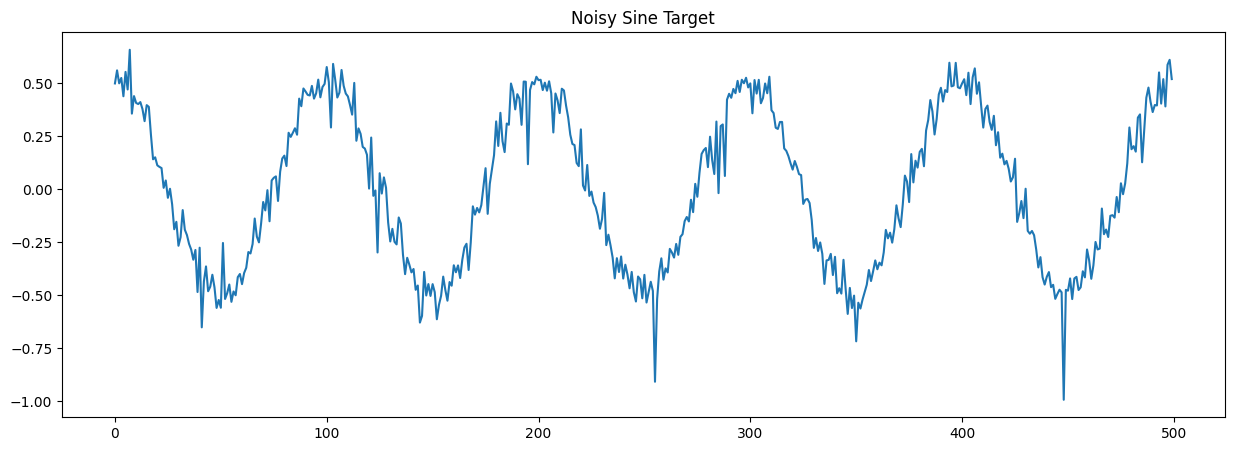

In [4]:
large_wave = WaveGen(size=500).linear_phase().cos().amp(.5).t_noise(std=.05, dof=3).sample(1).samples.squeeze(axis=0)
print(large_wave.shape)
plt.figure(figsize=(15,5))
plt.plot(large_wave)
plt.title('Noisy Sine Target')
plt.show()

In [5]:
# https://jamesmccaffrey.wordpress.com/2021/08/30/an-example-of-a-bayesian-neural-network-using-pytorch/bayesian_neural_network_demo/
class SineBayesianRegressor(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, prior_mu=0, prior_sigma=.1, negative_slope=.03):
        super(SineBayesianRegressor, self).__init__()
        self.input = bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=input_size, out_features=hidden_size)
        self.lrelu = nn.LeakyReLU(negative_slope=negative_slope)
        self.output = bnn.BayesLinear(prior_mu=prior_mu, prior_sigma=prior_sigma, in_features=hidden_size, out_features=output_size)
        return
        
    def forward(self, x):
        x = self.input(x)
        x = self.lrelu(x)
        x = self.output(x)
        return x
    
class SineMCDropout(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, dropout=.5):
        super(SineMCDropout, self).__init__()
        self._dropout = .5
        self.input = nn.Linear(input_size, hidden_size)
        self.drop = nn.Dropout(dropout)
        self.output = nn.Linear(hidden_size, output_size)
        return

    def forward(self, x):
        x = self.input(x)
        x = self.drop(x)
        x = self.output(x)
        return x
    
    def adjust_dropout(self, dropout):
        self._droupout = dropout
        self.drop = nn.Dropout(dropout)
        return

In [6]:
def train(
    model, 
    train_dataset,
    test_dataset,
    n_epochs=1000,
    batch_size=64,
    criterion=torch.nn.MSELoss(),
    optimizer=torch.optim.RMSprop,
    early_stop_patience=0,
    test_full=True,
):
    optimizer = optimizer(model.parameters())
    train_dataloader = DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=int(batch_size), shuffle=True)
    
    if early_stop_patience:
        patience = 0
        model_buffer = None
        loss_buffer = torch.tensor(float('inf'))

    items = list()
    for epoch in range(n_epochs):
        for (train_in_sample, train_forward_sample), (test_in_sample, test_forward_sample) in zip(train_dataloader, test_dataloader):
            optimizer.zero_grad()
            train_sample = model(train_in_sample)
            
            train_loss = criterion(train_sample, train_forward_sample)       
            train_loss.backward()
            optimizer.step()

            test_sample = model(test_in_sample)
            test_loss = criterion(test_sample, test_forward_sample)
                
        if test_full:
            # train all available non-overlapping periods
            full_set = train_dataset if len(train_dataset) < len(test_dataset) else test_dataset
            train_loss, test_loss = 0, 0
            for i in range(0, len(full_set), full_set.train_size):
                train_in, train_forward = train_dataset[i]
                test_in, test_forward = test_dataset[i]

                train_wave = model(train_in)
                train_loss += criterion(train_wave, train_forward)

                test_wave = model(test_in)
                test_loss += criterion(test_wave, test_forward)
            
            if early_stop_patience:
                if test_loss > loss_buffer:
                    patience += 1
                    if patience >= early_stop_patience:
                        items = items[:-early_stop_patience]
                        model = model_buffer
                        break
                else:
                    model_buffer = model
                    loss_buffer = test_loss
        elif early_stop_patience:
            warnings.warn('Early Stopping Patience argument unused, full data evaluation at end of epochs is disabled. \n Set test_full to True for early stopping.')
        
        items.append((train_loss.item(), test_loss.item()))
    return model, items

def plot_loss(loss, title='', step=1):
    train_loss, test_loss = zip(*loss)

    plt.figure(figsize=(16,8))
    colors = sns.color_palette('Spectral', 8)
    sns.lineplot(train_loss[::step], dashes=False, color=colors[0], label='Train MSE')
    sns.lineplot(test_loss[::step], dashes=False, color=colors[0], label='Test MSE')
    if title:
        plt.title(title)
    plt.legend()
    plt.show()
    return

In [7]:
input_sizes = [64,128,192]
sizes = [128,192,256]
hidden_sizes = [2, 4, 8, 16, 32, 64, 96, 128]

columns = ['input_size','output_size','hidden_size','train_loss','test_loss']
total_i = np.prod([len(input_sizes),len(sizes),len(hidden_sizes)])
rows = list()
n_epochs = 30
batch_size = 32

split = .5
train_test_wave = torch.from_numpy(large_wave)
split_idx = int(train_test_wave.shape[0] * split)
train_wave = train_test_wave[:split_idx]
test_wave = train_test_wave[split_idx:]

for i, (input_size, size, hidden_size) in enumerate(itertools.product(input_sizes, sizes, hidden_sizes)):
    if size <= input_size or size > min(len(train_wave), len(test_wave)): continue
        
    print('Input Set', i + 1, 'out of', total_i, end='\n')
    print(input_size, size, hidden_size, sep='|')
    output_size = size - input_size
    
    train_dataset = TorchTimesplitDataset(train_wave, split=input_size, size=size)
    test_dataset = TorchTimesplitDataset(test_wave, split=input_size, size=size)
    
    model = SineBayesianRegressor(
        input_size, 
        output_size, 
        hidden_size, 
        prior_mu=0, 
        prior_sigma=.1,
    ).double()
    
    try:
        model, loss = train(
            model, 
            train_dataset,
            test_dataset,
            n_epochs=n_epochs, 
            batch_size=batch_size, 
            test_full=True,
            early_stop_patience=5,
        )
    except RuntimeError as re:
        warnings.warn(str(re))
        continue
        
    if not len(loss):
        print('Missing loss')
        continue
    rows.append((input_size, output_size, hidden_size, loss[-1][0], loss[-1][1]))

Input Set 1 out of 72
64|128|2
Input Set 2 out of 72
64|128|4
Input Set 3 out of 72
64|128|8
Input Set 4 out of 72
64|128|16
Input Set 5 out of 72
64|128|32
Input Set 6 out of 72
64|128|64
Input Set 7 out of 72
64|128|96
Input Set 8 out of 72
64|128|128
Input Set 9 out of 72
64|192|2
Input Set 10 out of 72
64|192|4
Input Set 11 out of 72
64|192|8
Input Set 12 out of 72
64|192|16
Input Set 13 out of 72
64|192|32
Input Set 14 out of 72
64|192|64
Input Set 15 out of 72
64|192|96
Input Set 16 out of 72
64|192|128
Input Set 33 out of 72
128|192|2
Input Set 34 out of 72
128|192|4
Input Set 35 out of 72
128|192|8
Input Set 36 out of 72
128|192|16
Input Set 37 out of 72
128|192|32
Input Set 38 out of 72
128|192|64
Input Set 39 out of 72
128|192|96
Input Set 40 out of 72
128|192|128


In [8]:
grid_df = pd.DataFrame(rows, columns=columns)
assert grid_df.shape[1] == len(columns), f'{grid_df.shape[1]} != {len(columns)}'
grid_df.columns = columns
grid_df.to_csv(f'training_io_{pd.to_datetime("today").strftime("%Y-%m-%d:%H")}.csv')
display(grid_df)

,input_size,output_size,hidden_size,train_loss,test_loss
0,64,64,2,0.210978,0.222791
1,64,64,4,0.160968,0.152422
2,64,64,8,0.161607,0.125789
3,64,64,16,0.145186,0.075583
4,64,64,32,0.171275,0.152793
5,64,64,64,0.191789,0.141514
6,64,64,96,0.188825,0.188868
7,64,64,128,0.361777,0.218109
8,64,128,2,0.170655,0.103755
9,64,128,4,0.172584,0.132024


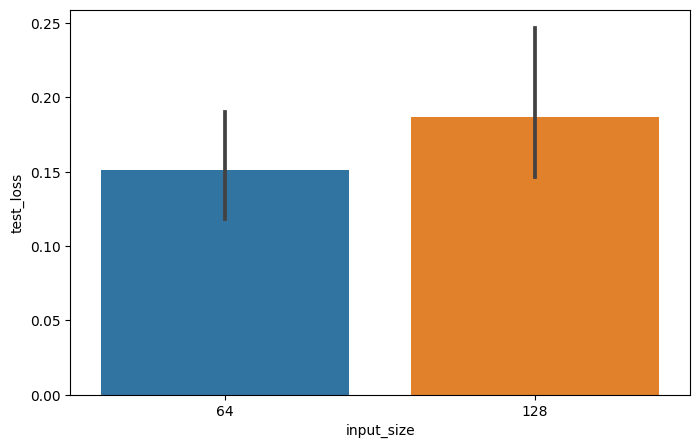

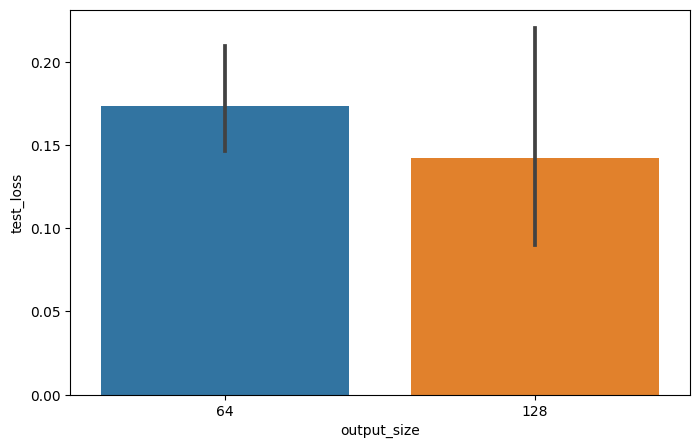

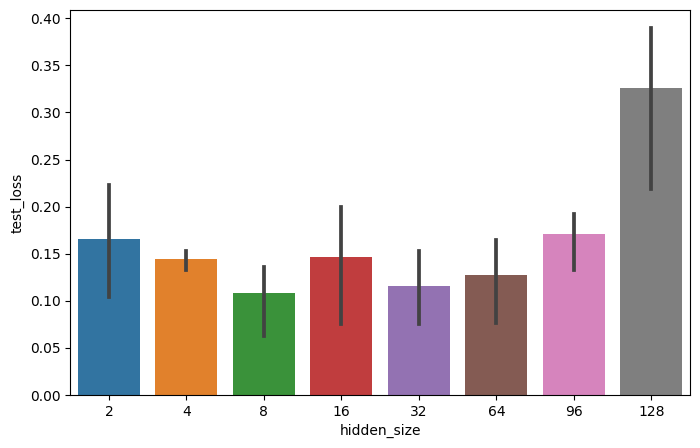

In [9]:
for col in columns[:-2]:
    plt.figure(figsize=(8,5))
    sns.barplot(data=grid_df, x=col, y='test_loss')
    plt.show()

In [10]:
best_param_df = grid_df.loc[grid_df['test_loss'].idxmin(),grid_df.columns[:-2]]
display(best_param_df)
best_input_size, best_output_size, best_hidden_size = best_param_df.to_numpy()
display(f'Best Input Size {best_input_size}', f'Best Output Size {best_output_size}', f'Best Hidden Size {best_hidden_size}')


best_train_dataset = TorchTimesplitDataset(train_wave, split=best_input_size, size=best_input_size + best_output_size)
best_test_dataset = TorchTimesplitDataset(test_wave, split=best_input_size, size=best_input_size + best_output_size)
    
best_bayes_model = SineBayesianRegressor(
    int(best_input_size), 
    int(best_output_size), 
    int(best_hidden_size), 
    prior_mu=0, 
    prior_sigma=.1,
).double()

best_bayes_model, best_bayes_loss = train(
    best_bayes_model, 
    best_train_dataset,
    best_test_dataset,
    n_epochs=100, 
    batch_size=64, 
    early_stop_patience=30,
)


best_mcdrop_model = SineMCDropout(
    int(best_input_size), 
    int(best_output_size), 
    int(best_hidden_size), 
    dropout=.3,
).double()
    
best_mcdrop_model, best_mcdrop_loss = train(
    best_mcdrop_model, 
    best_train_dataset,
    best_test_dataset,
    n_epochs=100, 
    batch_size=64, 
    early_stop_patience=30,
)

input_size      64.0
output_size    128.0
hidden_size      8.0
Name: 10, dtype: float64

'Best Input Size 64.0'

'Best Output Size 128.0'

'Best Hidden Size 8.0'

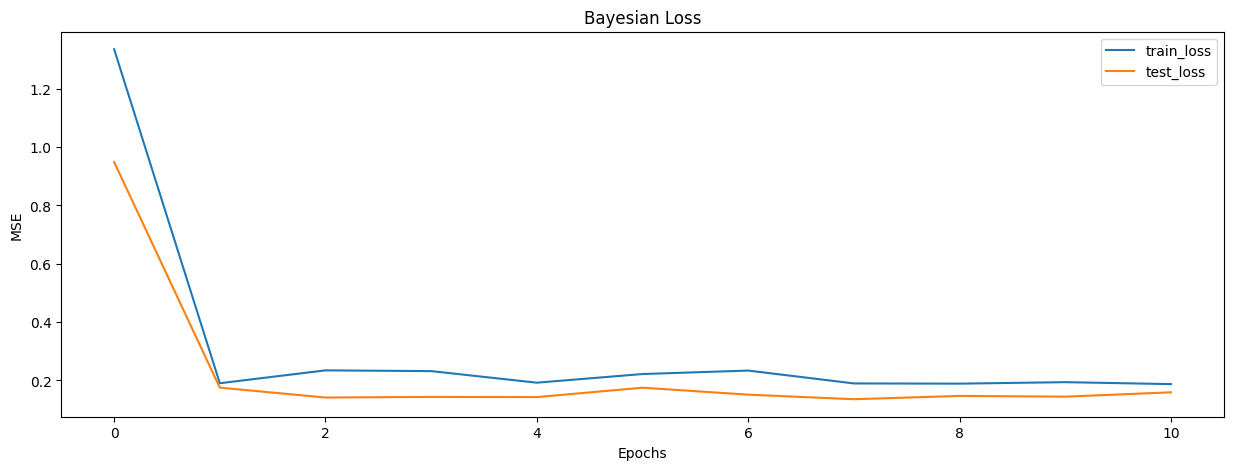

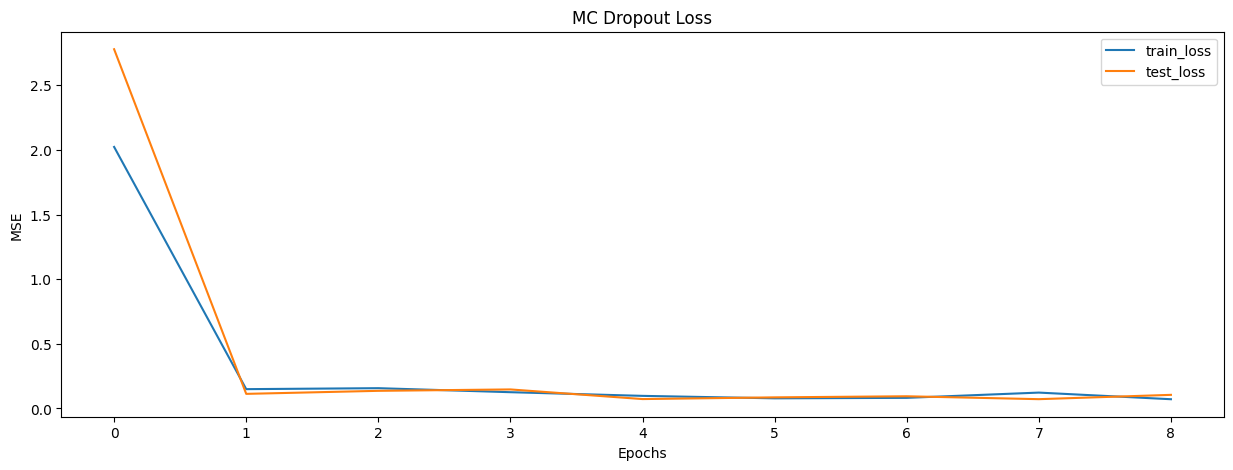

In [12]:
def plot_loss(loss, tt=True, ylabel='MSE', title='Loss Vs Epochs'):
    plt.figure(figsize=(15,5))
    if tt:
        train_loss, test_loss = zip(*loss)
        plt.plot(train_loss, label='train_loss')
        plt.plot(test_loss, label='test_loss')
    else:
        plt.plot(loss, label='loss')
    plt.xlabel('Epochs')
    plt.ylabel(ylabel)
    plt.legend()
    plt.title(title)
    plt.show()
    return

plot_loss(best_bayes_loss, title='Bayesian Loss')
plot_loss(best_mcdrop_loss, title='MC Dropout Loss')

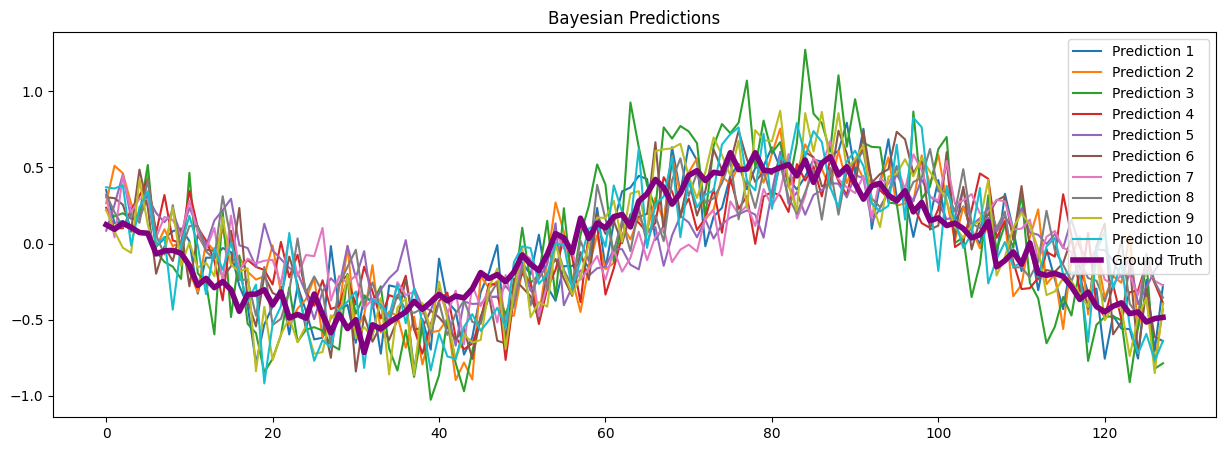

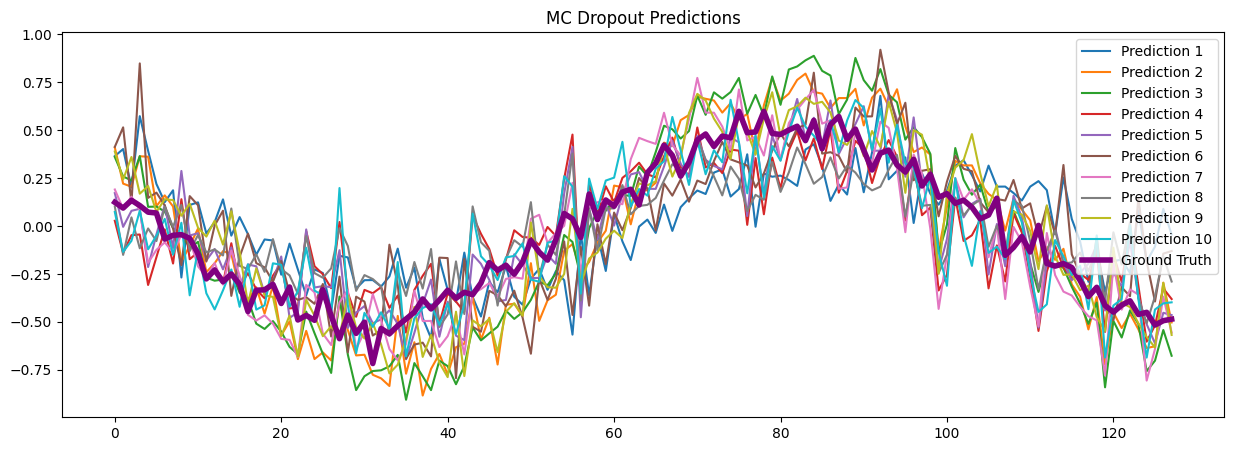

In [14]:
def plot_probabilistic(model, n_paths=10, title='Probabilistic Predictions'):
    plt.figure(figsize=(15,5))
    rand_sample_in, rand_sample_forward = best_test_dataset[5]
    for i in range(n_paths):
        plt.plot(model(rand_sample_in).detach().numpy(), label='Prediction ' + str(i + 1))
    plt.plot(rand_sample_forward, color='purple', linewidth=4, label='Ground Truth')
    plt.legend()
    plt.title(title)
    plt.show()
    return

plot_probabilistic(best_bayes_model, title='Bayesian Predictions')
plot_probabilistic(best_mcdrop_model, title='MC Dropout Predictions')

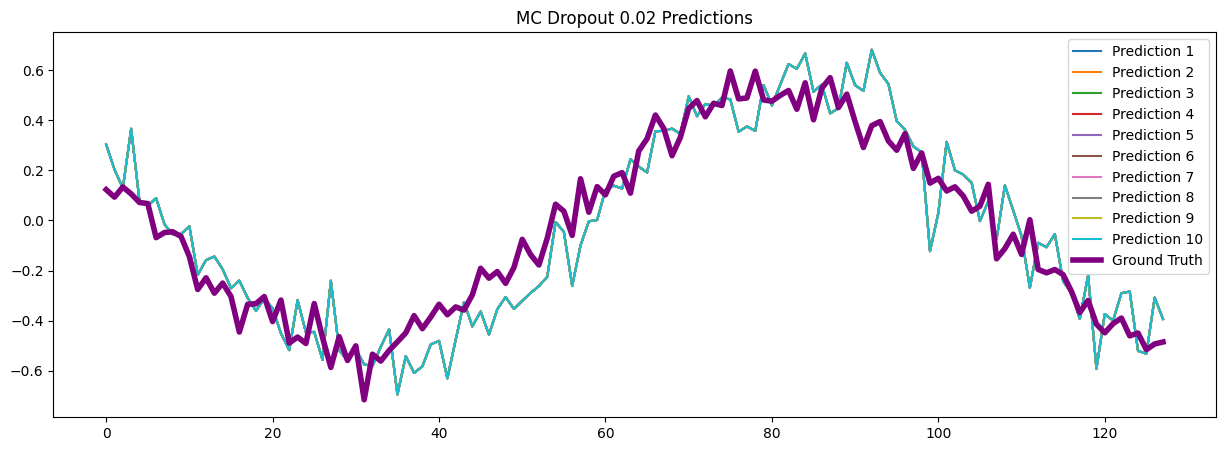

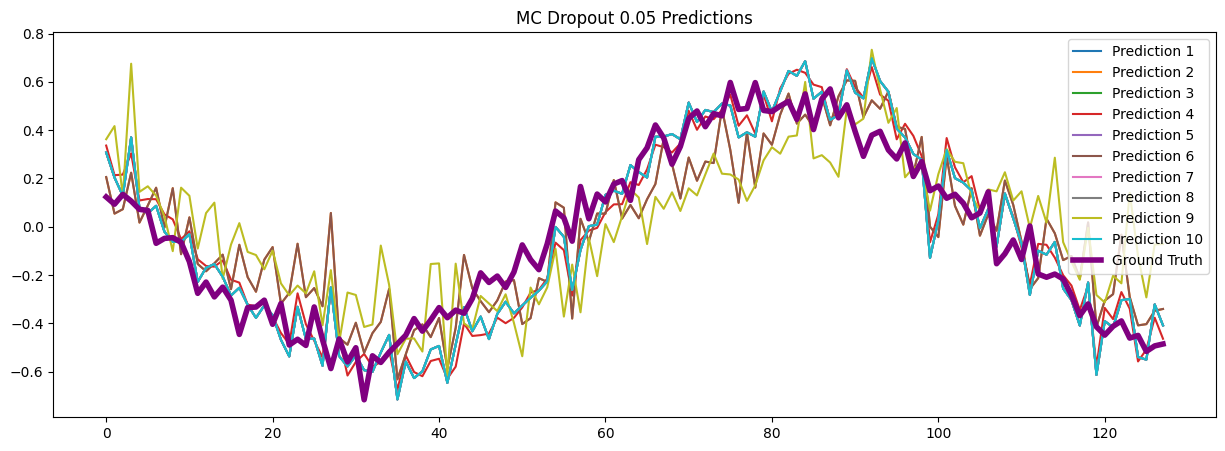

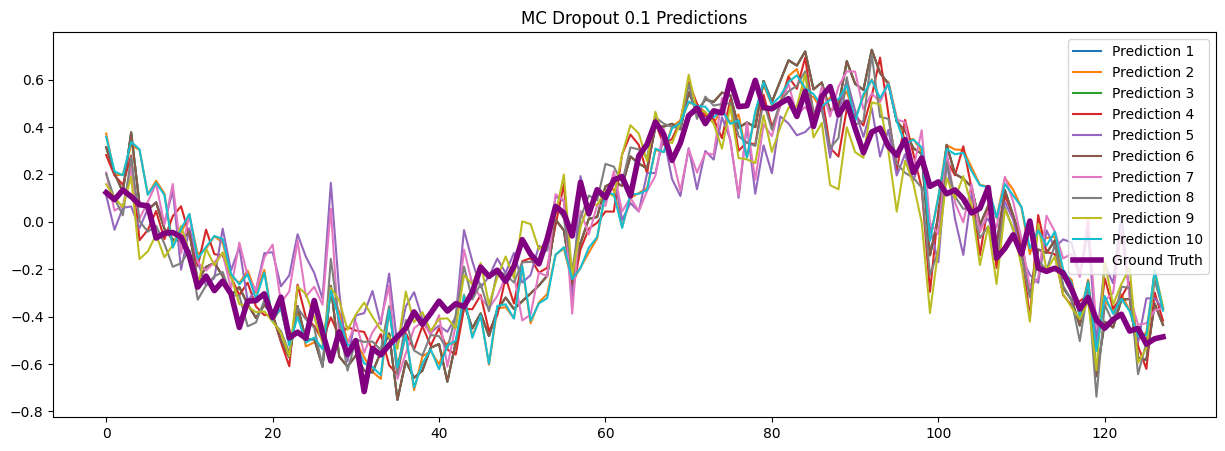

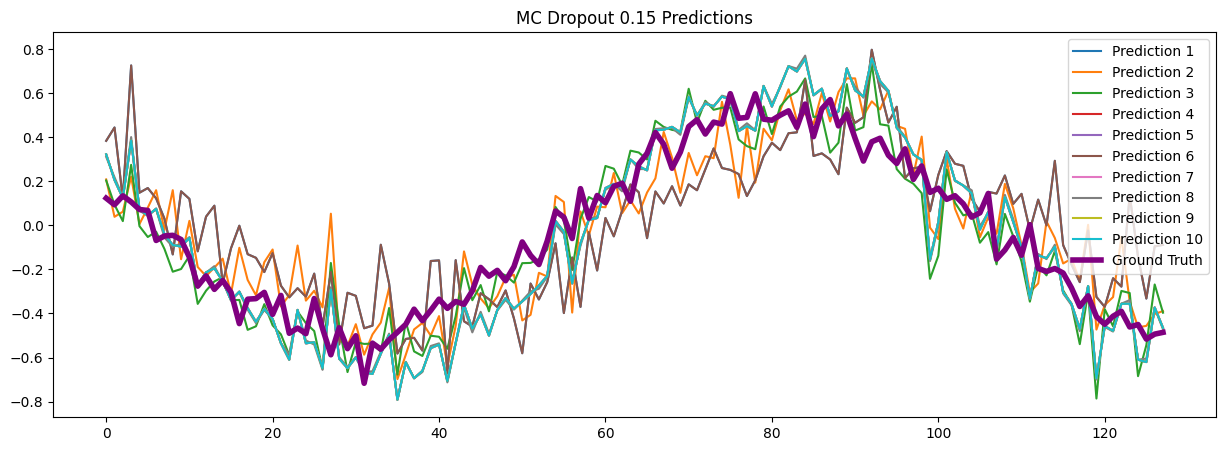

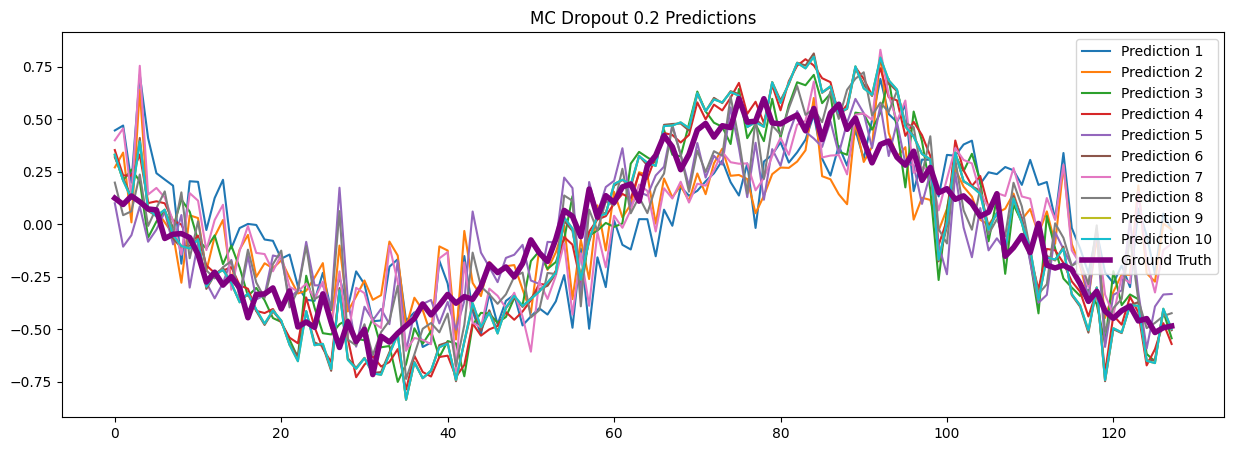

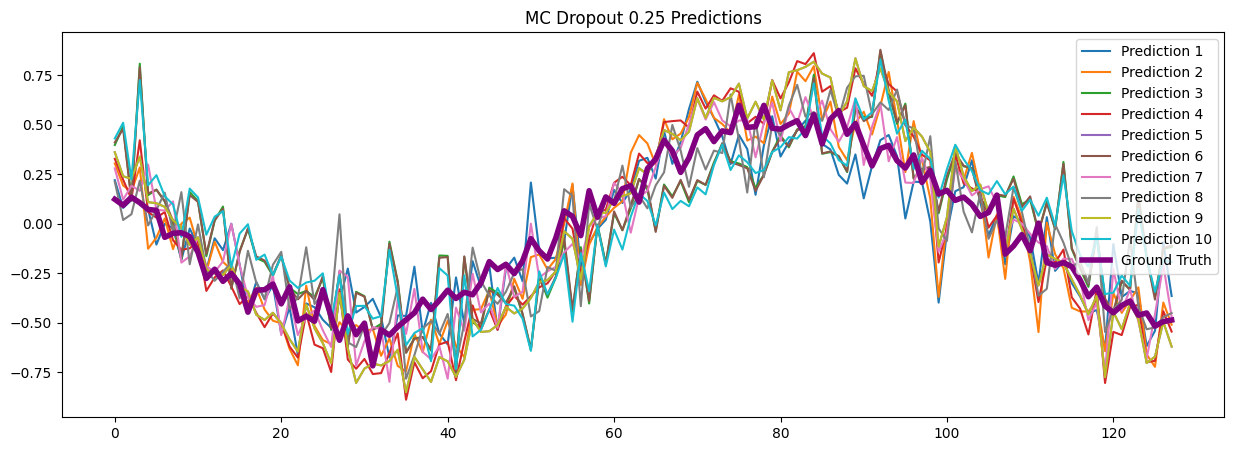

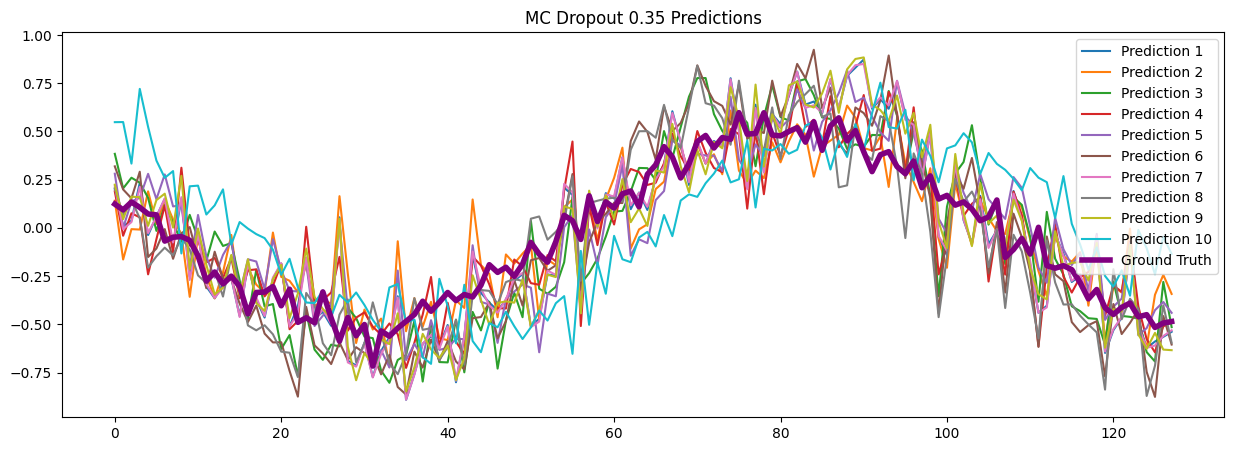

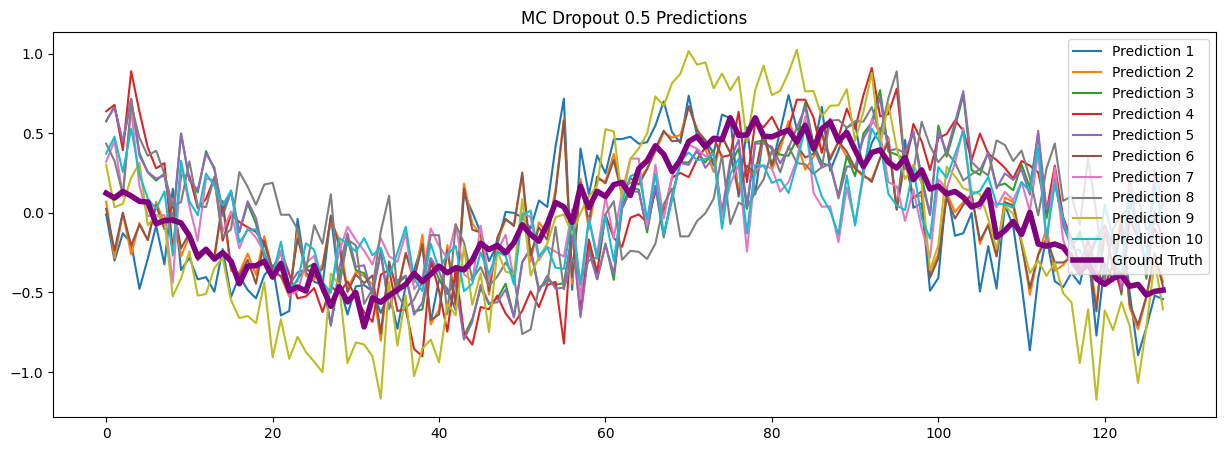

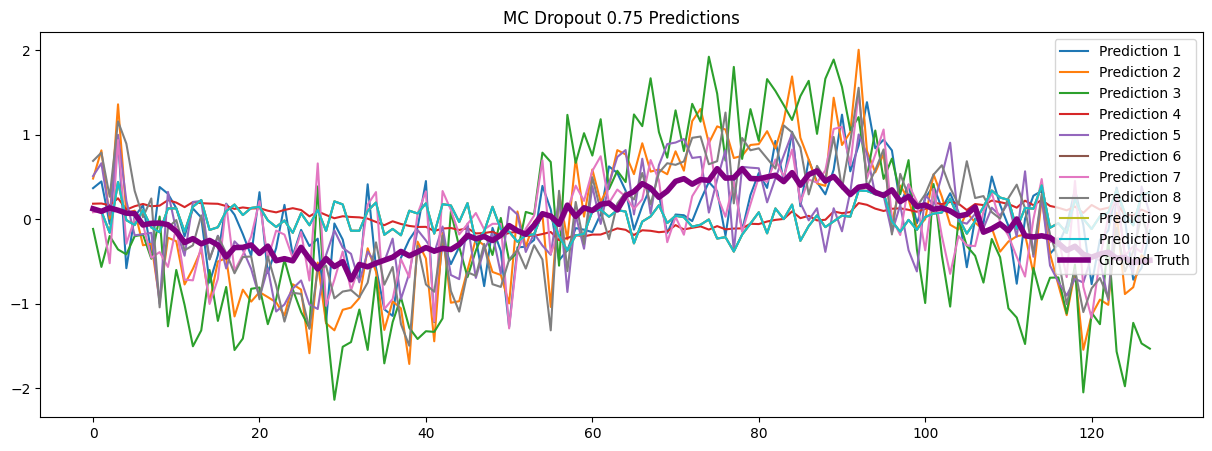

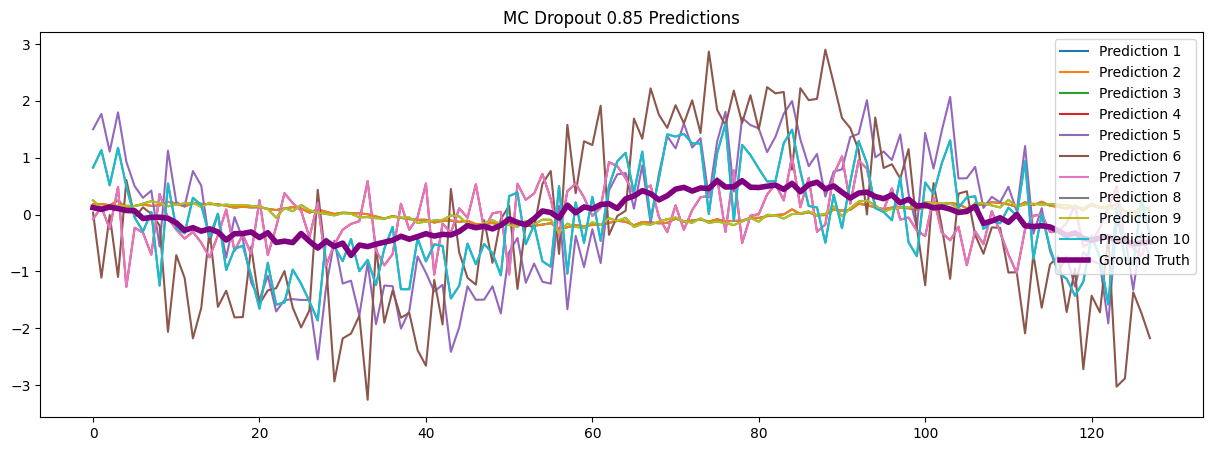

In [17]:
mcdrop_clone = deepcopy(best_mcdrop_model)
for dropout in [.02,.05,.1,.15,.2,.25,.35,.5,.75,.85]:
    mcdrop_clone.adjust_dropout(dropout)
    plot_probabilistic(mcdrop_clone, title=f'MC Dropout {dropout} Predictions')